In [74]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_absolute_error
from yellowbrick.text import TSNEVisualizer
from sklearn.ensemble import GradientBoostingRegressor
from datetime import datetime
%matplotlib inline

In [2]:
main = pd.read_csv("datasets/ted_main.csv")
main.head(2)

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520


In [3]:
transcripts = pd.read_csv("datasets/transcripts.csv")
transcripts.head(2)

,transcript,url
0,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...
1,"Thank you so much, Chris. And it's truly a gre...",https://www.ted.com/talks/al_gore_on_averting_...


In [4]:
df = main.merge(transcripts, how="left", on="url")
df.head()

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views,transcript
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,Good morning. How are you?(Laughter)It's been ...
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520,"Thank you so much, Chris. And it's truly a gre..."
2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292,"(Music: ""The Sound of Silence,"" Simon & Garfun..."
3,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,"[{'id': 3, 'name': 'Courageous', 'count': 760}...","[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",Activist for environmental justice,"['MacArthur grant', 'activism', 'business', 'c...",Greening the ghetto,https://www.ted.com/talks/majora_carter_s_tale...,1697550,If you're here today — and I'm very happy that...
4,593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,1151440680,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",Global health expert; data visionary,"['Africa', 'Asia', 'Google', 'demo', 'economic...",The best stats you've ever seen,https://www.ted.com/talks/hans_rosling_shows_t...,12005869,"About 10 years ago, I took on the task to teac..."


In [5]:
rating_lst = []
for entry in df["ratings"]:
    for rating in eval(entry):
        if rating["name"] in rating_lst:
            continue
        else: 
            rating_lst.append(rating["name"])
rating_lst, len(rating_lst)

(['Funny',
  'Beautiful',
  'Ingenious',
  'Courageous',
  'Longwinded',
  'Confusing',
  'Informative',
  'Fascinating',
  'Unconvincing',
  'Persuasive',
  'Jaw-dropping',
  'OK',
  'Obnoxious',
  'Inspiring'],
 14)

In [6]:
lsts = {}
maximum_lst = []
for entry in df["ratings"]:
    diction = eval(entry)
    for rating in diction:
        if rating["name"] not in lsts: 
            lsts[rating["name"]] = [rating["count"]]
        else: 
            lsts[rating["name"]].append(rating["count"])
        

In [7]:
restruc_lst = []
for entry in df["ratings"]:
    diction = eval(entry)
    new_d = {}
    for d in diction:
        new_d[d["name"]] = d["count"]
    restruc_lst.append(new_d)       

In [8]:
max_rating = [max(d, key=d.get) for d in restruc_lst]

In [9]:
ratings_df = pd.DataFrame.from_dict(lsts)
ratings_df.head()

,Funny,Beautiful,Ingenious,Courageous,Longwinded,Confusing,Informative,Fascinating,Unconvincing,Persuasive,Jaw-dropping,OK,Obnoxious,Inspiring
0,19645,4573,6073,3253,387,242,7346,10581,300,10704,4439,1174,209,24924
1,544,58,56,139,113,62,443,132,258,268,116,203,131,413
2,964,60,183,45,78,27,395,166,104,230,54,146,142,230
3,59,291,105,760,53,32,380,132,36,460,230,85,35,1070
4,1390,942,3202,318,110,72,5433,4606,67,2542,3736,248,61,2893


In [10]:
len(ratings_df)

2553

In [11]:
ratings_df["url"] = df["url"]
ratings_df.head(2)

,Funny,Beautiful,Ingenious,Courageous,Longwinded,Confusing,Informative,Fascinating,Unconvincing,Persuasive,Jaw-dropping,OK,Obnoxious,Inspiring,url
0,19645,4573,6073,3253,387,242,7346,10581,300,10704,4439,1174,209,24924,https://www.ted.com/talks/ken_robinson_says_sc...
1,544,58,56,139,113,62,443,132,258,268,116,203,131,413,https://www.ted.com/talks/al_gore_on_averting_...


In [12]:
ratings_df["max_rating"] = max_rating

In [13]:
df = df.merge(ratings_df, how="left", on="url").drop(columns="ratings")
df.head(2)

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,...,Confusing,Informative,Fascinating,Unconvincing,Persuasive,Jaw-dropping,OK,Obnoxious,Inspiring,max_rating
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,...,242,7346,10581,300,10704,4439,1174,209,24924,Inspiring
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,...,62,443,132,258,268,116,203,131,413,Funny


In [14]:
eval(df.iloc[0]["related_talks"])

[{'id': 865,
  'hero': 'https://pe.tedcdn.com/images/ted/172559_800x600.jpg',
  'speaker': 'Ken Robinson',
  'title': 'Bring on the learning revolution!',
  'duration': 1008,
  'slug': 'sir_ken_robinson_bring_on_the_revolution',
  'viewed_count': 7266103},
 {'id': 1738,
  'hero': 'https://pe.tedcdn.com/images/ted/de98b161ad1434910ff4b56c89de71af04b8b873_1600x1200.jpg',
  'speaker': 'Ken Robinson',
  'title': "How to escape education's death valley",
  'duration': 1151,
  'slug': 'ken_robinson_how_to_escape_education_s_death_valley',
  'viewed_count': 6657572},
 {'id': 2276,
  'hero': 'https://pe.tedcdn.com/images/ted/3821f3728e0b755c7b9aea2e69cc093eca41abe1_2880x1620.jpg',
  'speaker': 'Linda Cliatt-Wayman',
  'title': 'How to fix a broken school? Lead fearlessly, love hard',
  'duration': 1027,
  'slug': 'linda_cliatt_wayman_how_to_fix_a_broken_school_lead_fearlessly_love_hard',
  'viewed_count': 1617101},
 {'id': 892,
  'hero': 'https://pe.tedcdn.com/images/ted/e79958940573cc610ccb58

In [15]:
df.columns

Index(['comments', 'description', 'duration', 'event', 'film_date',
       'languages', 'main_speaker', 'name', 'num_speaker', 'published_date',
       'related_talks', 'speaker_occupation', 'tags', 'title', 'url', 'views',
       'transcript', 'Funny', 'Beautiful', 'Ingenious', 'Courageous',
       'Longwinded', 'Confusing', 'Informative', 'Fascinating', 'Unconvincing',
       'Persuasive', 'Jaw-dropping', 'OK', 'Obnoxious', 'Inspiring',
       'max_rating'],
      dtype='object')

In [16]:
df["film_date"] = df["film_date"].apply(lambda d: datetime.utcfromtimestamp(d).strftime('%Y-%m-%d %H:%M:%S'))
df["published_date"] = df["published_date"].apply(lambda d: datetime.utcfromtimestamp(d).strftime('%Y-%m-%d %H:%M:%S'))

In [17]:
df.head()

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,...,Confusing,Informative,Fascinating,Unconvincing,Persuasive,Jaw-dropping,OK,Obnoxious,Inspiring,max_rating
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,2006-02-25 00:00:00,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,2006-06-27 00:11:00,...,242,7346,10581,300,10704,4439,1174,209,24924,Inspiring
1,265,With the same humor and humanity he exuded in ...,977,TED2006,2006-02-25 00:00:00,43,Al Gore,Al Gore: Averting the climate crisis,1,2006-06-27 00:11:00,...,62,443,132,258,268,116,203,131,413,Funny
2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,2006-02-24 00:00:00,26,David Pogue,David Pogue: Simplicity sells,1,2006-06-27 00:11:00,...,27,395,166,104,230,54,146,142,230,Funny
3,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,2006-02-26 00:00:00,35,Majora Carter,Majora Carter: Greening the ghetto,1,2006-06-27 00:11:00,...,32,380,132,36,460,230,85,35,1070,Inspiring
4,593,You've never seen data presented like this. Wi...,1190,TED2006,2006-02-22 00:00:00,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,2006-06-27 20:38:00,...,72,5433,4606,67,2542,3736,248,61,2893,Informative


In [18]:
df["yr"] = pd.to_datetime(df["published_date"]).dt.year
df["month"] = pd.to_datetime(df["published_date"]).dt.month
df.head(2)

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,...,Fascinating,Unconvincing,Persuasive,Jaw-dropping,OK,Obnoxious,Inspiring,max_rating,yr,month
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,2006-02-25 00:00:00,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,2006-06-27 00:11:00,...,10581,300,10704,4439,1174,209,24924,Inspiring,2006,6
1,265,With the same humor and humanity he exuded in ...,977,TED2006,2006-02-25 00:00:00,43,Al Gore,Al Gore: Averting the climate crisis,1,2006-06-27 00:11:00,...,132,258,268,116,203,131,413,Funny,2006,6


In [19]:
df = df.drop(columns=["film_date", "published_date", "event"])
df.head(2)

,comments,description,duration,languages,main_speaker,name,num_speaker,related_talks,speaker_occupation,tags,...,Fascinating,Unconvincing,Persuasive,Jaw-dropping,OK,Obnoxious,Inspiring,max_rating,yr,month
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,"[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",...,10581,300,10704,4439,1174,209,24924,Inspiring,2006,6
1,265,With the same humor and humanity he exuded in ...,977,43,Al Gore,Al Gore: Averting the climate crisis,1,"[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",...,132,258,268,116,203,131,413,Funny,2006,6


In [20]:
df.corr().style.background_gradient(cmap='coolwarm')

,comments,duration,languages,num_speaker,views,Funny,Beautiful,Ingenious,Courageous,Longwinded,Confusing,Informative,Fascinating,Unconvincing,Persuasive,Jaw-dropping,OK,Obnoxious,Inspiring,yr,month
comments,1,0.143003,0.319834,-0.0358839,0.532663,0.360972,0.395965,0.440565,0.53935,0.455397,0.381361,0.510921,0.538234,0.449177,0.636844,0.331288,0.471782,0.408704,0.56099,-0.182252,-0.0280815
duration,0.143003,1,-0.295341,0.0221387,0.050918,0.00444946,0.0335741,0.00815399,0.113422,0.303967,0.0845995,0.116162,0.113343,0.0334298,0.132451,0.0398438,-0.0774878,0.0596765,0.0943666,-0.162225,-0.0332418
languages,0.319834,-0.295341,1,-0.0634501,0.379116,0.22567,0.23057,0.274574,0.214052,0.153645,0.184977,0.324378,0.285673,0.202649,0.291916,0.16077,0.431492,0.132237,0.278923,-0.172542,0.0172695
num_speaker,-0.0358839,0.0221387,-0.0634501,1,-0.0267085,-0.0190052,-0.00582195,-0.0236396,-0.032894,-0.0521929,-0.0242729,-0.0557006,-0.0322406,-0.0342269,-0.0489664,-0.00750224,-0.0442227,-0.0107342,-0.0344112,0.0478528,0.015185
views,0.532663,0.050918,0.379116,-0.0267085,1,0.59505,0.557704,0.60413,0.559258,0.452669,0.409944,0.759785,0.773583,0.277879,0.726548,0.441756,0.699035,0.250902,0.776957,-0.0161764,-0.0183657
Funny,0.360972,0.00444946,0.22567,-0.0190052,0.59505,1,0.298418,0.551033,0.259703,0.28319,0.268783,0.391576,0.442171,0.132951,0.504821,0.213811,0.431816,0.205212,0.483073,-0.104771,-0.0250347
Beautiful,0.395965,0.0335741,0.23057,-0.00582195,0.557704,0.298418,1,0.308781,0.603274,0.306485,0.243757,0.396805,0.611806,0.129572,0.387637,0.427178,0.36495,0.156645,0.707748,-0.0386917,-0.0109112
Ingenious,0.440565,0.00815399,0.274574,-0.0236396,0.60413,0.551033,0.308781,1,0.229186,0.276619,0.280667,0.503879,0.659785,0.164246,0.530578,0.56433,0.429207,0.160114,0.522713,-0.17225,-0.0211519
Courageous,0.53935,0.113422,0.214052,-0.032894,0.559258,0.259703,0.603274,0.229186,1,0.319659,0.251057,0.453753,0.483254,0.201436,0.503355,0.29492,0.350561,0.228604,0.707519,-0.00205535,-0.0274915
Longwinded,0.455397,0.303967,0.153645,-0.0521929,0.452669,0.28319,0.306485,0.276619,0.319659,1,0.634333,0.416909,0.442884,0.516064,0.457365,0.223866,0.625633,0.519862,0.428093,-0.341984,0.0122327


In [21]:
min(df["yr"]), max(df["yr"])

(2006, 2017)

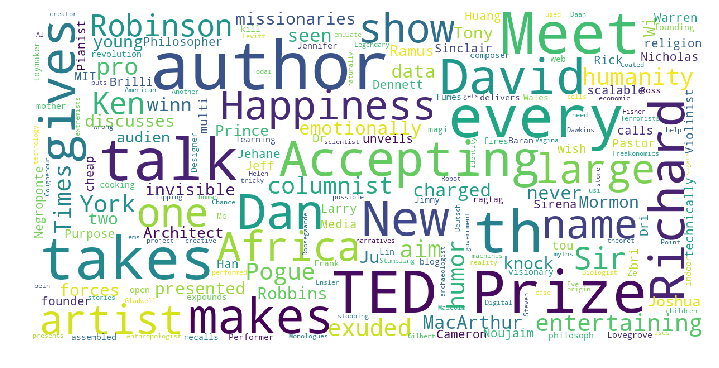

In [22]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(df['description'])

****2006****


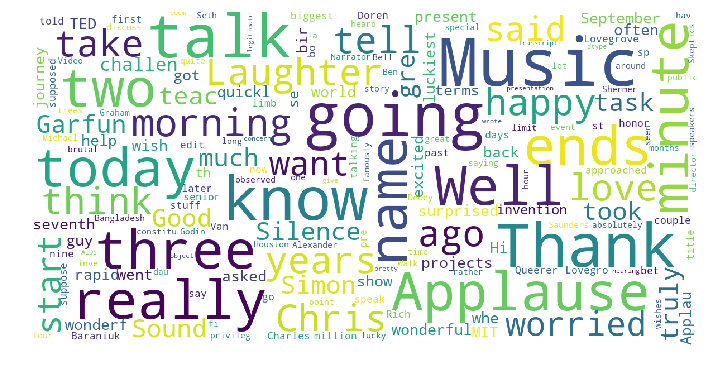

****2008****


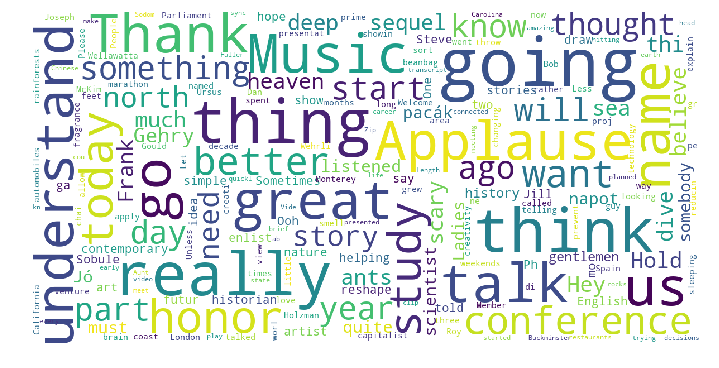

****2010****


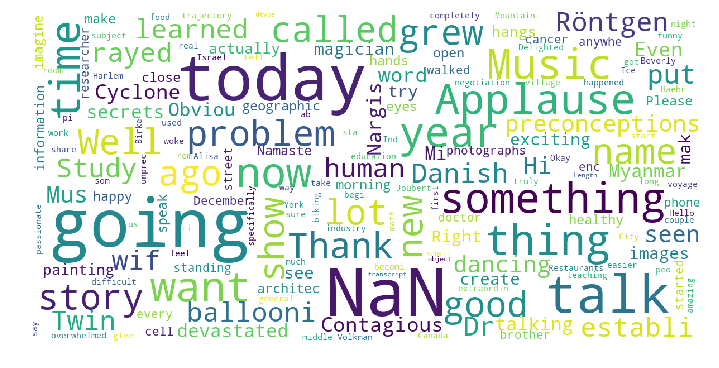

****2012****


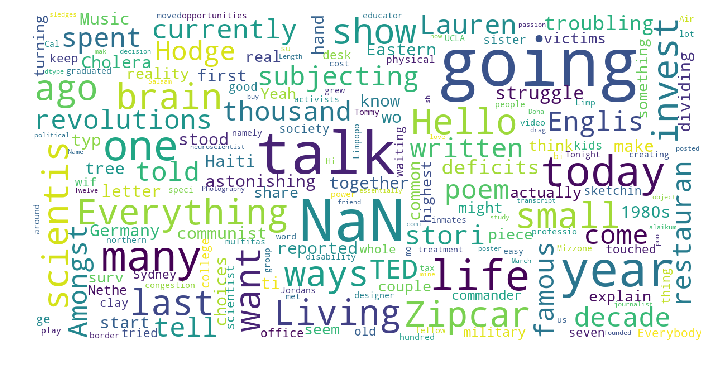

****2014****


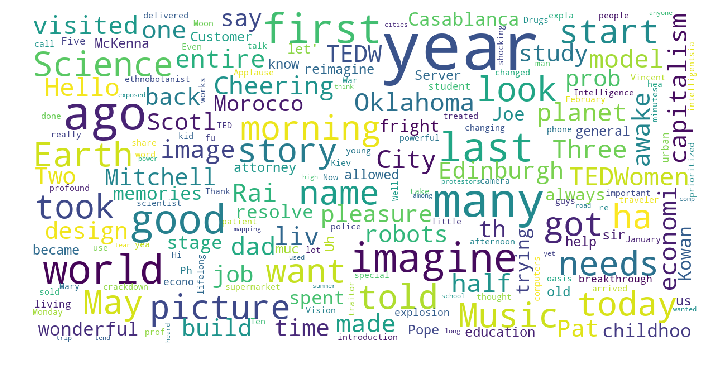

****2016****


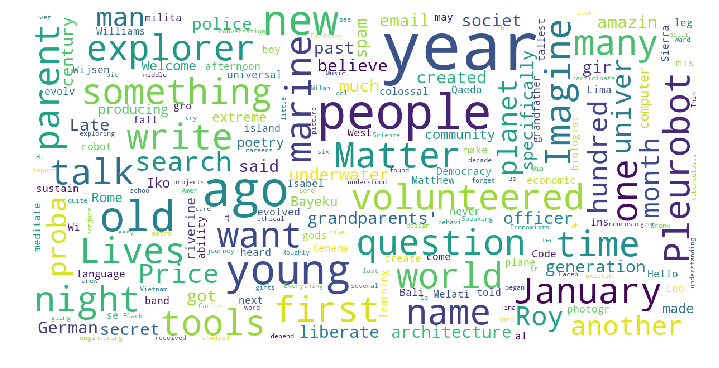

In [23]:
for year in range(2006, 2018, 2):
    by_yr_df = df[df["yr"]==year]
    print("****{}****".format(str(year)))
    show_wordcloud(by_yr_df["transcript"])

In [24]:
tfidf = TfidfVectorizer()

In [25]:
len(df), len(df.dropna())

(2559, 2467)

In [26]:
df = df.dropna()

In [27]:
X = tfidf.fit_transform(df["transcript"])

In [28]:
y = df["max_rating"]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

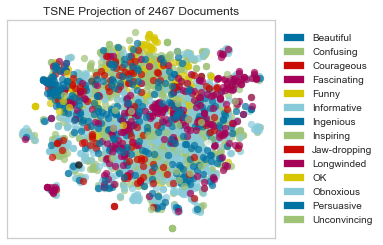

In [29]:
tsne = TSNEVisualizer()
tsne.fit(X, y)
tsne.show()

In [30]:
df

,comments,description,duration,languages,main_speaker,name,num_speaker,related_talks,speaker_occupation,tags,...,Fascinating,Unconvincing,Persuasive,Jaw-dropping,OK,Obnoxious,Inspiring,max_rating,yr,month
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,"[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",...,10581,300,10704,4439,1174,209,24924,Inspiring,2006,6
1,265,With the same humor and humanity he exuded in ...,977,43,Al Gore,Al Gore: Averting the climate crisis,1,"[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",...,132,258,268,116,203,131,413,Funny,2006,6
2,124,New York Times columnist David Pogue takes aim...,1286,26,David Pogue,David Pogue: Simplicity sells,1,"[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",...,166,104,230,54,146,142,230,Funny,2006,6
3,200,"In an emotionally charged talk, MacArthur-winn...",1116,35,Majora Carter,Majora Carter: Greening the ghetto,1,"[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",Activist for environmental justice,"['MacArthur grant', 'activism', 'business', 'c...",...,132,36,460,230,85,35,1070,Inspiring,2006,6
4,593,You've never seen data presented like this. Wi...,1190,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,"[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",Global health expert; data visionary,"['Africa', 'Asia', 'Google', 'demo', 'economic...",...,4606,67,2542,3736,248,61,2893,Informative,2006,6
5,672,"Tony Robbins discusses the ""invisible forces"" ...",1305,36,Tony Robbins,Tony Robbins: Why we do what we do,1,"[{'id': 229, 'hero': 'https://pe.tedcdn.com/im...",Life coach; expert in leadership psychology,"['business', 'culture', 'entertainment', 'goal...",...,1350,377,2423,669,441,335,5211,Inspiring,2006,6
6,919,When two young Mormon missionaries knock on Ju...,992,31,Julia Sweeney,Julia Sweeney: Letting go of God,1,"[{'id': 22, 'hero': 'https://pe.tedcdn.com/ima...","Actor, comedian, playwright","['Christianity', 'God', 'atheism', 'comedy', '...",...,316,225,311,61,308,290,438,Funny,2006,7
7,46,Architect Joshua Prince-Ramus takes the audien...,1198,19,Joshua Prince-Ramus,Joshua Prince-Ramus: Behind the design of Seat...,1,"[{'id': 750, 'hero': 'https://pe.tedcdn.com/im...",Architect,"['architecture', 'collaboration', 'culture', '...",...,153,26,37,57,63,5,175,Ingenious,2006,7
8,852,Philosopher Dan Dennett calls for religion -- ...,1485,32,Dan Dennett,Dan Dennett: Let's teach religion -- all relig...,1,"[{'id': 71, 'hero': 'https://pe.tedcdn.com/ima...","Philosopher, cognitive scientist","['God', 'TED Brain Trust', 'atheism', 'brain',...",...,313,283,764,60,154,83,441,Persuasive,2006,7
9,900,"Pastor Rick Warren, author of ""The Purpose-Dri...",1262,31,Rick Warren,Rick Warren: A life of purpose,1,"[{'id': 94, 'hero': 'https://pe.tedcdn.com/ima...","Pastor, author","['Christianity', 'God', 'culture', 'happiness'...",...,459,838,1543,209,245,371,2556,Inspiring,2006,7


C:\Users\pjd04\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


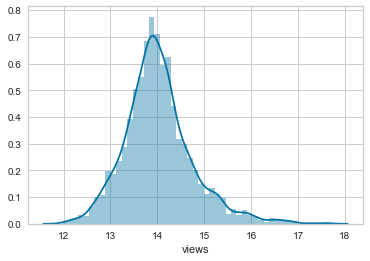

In [31]:
sns.distplot(np.log1p(df["views"]))

In [32]:
xtrain, xtest, ytrain, ytest = train_test_split(tfidf.fit_transform(df["transcript"]), 
                                                np.log1p(df["views"]), test_size=0.33, random_state=42)

In [33]:
svr = LinearSVR(random_state=42)

In [34]:
cv_results = cross_validate(svr, xtrain, ytrain, cv=5, scoring='neg_mean_squared_error', return_estimator=True)

In [35]:
cv_results

C:\Users\pjd04\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.10558939, 0.08652806, 0.08502984, 0.13453436, 0.08763194]),
 'score_time': array([0.        , 0.        , 0.00100398, 0.0010004 , 0.00099778]),
 'estimator': (LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
       intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
       random_state=42, tol=0.0001, verbose=0),
  LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
       intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
       random_state=42, tol=0.0001, verbose=0),
  LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
       intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
       random_state=42, tol=0.0001, verbose=0),
  LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
       intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
       random_state=42, tol=0.0001, verbose=0),
  LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
       intercept_scali

In [36]:
best_svr = LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
       intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
       random_state=42, tol=0.0001, verbose=0)

In [61]:
def mae(est):
    est.fit(xtrain, ytrain)
    return mean_absolute_error(np.expm1(ytest), np.expm1(est.predict(xtest)))

In [62]:
mae(best_svr)

941241.1915885289

In [63]:
lr = LinearRegression()
lr_cv_results = cross_validate(lr, xtrain, ytrain, cv=5, scoring='neg_mean_squared_error', return_estimator=True)

In [64]:
lr_cv_results

C:\Users\pjd04\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.2304132 , 0.2224052 , 0.22938657, 0.24673939, 0.20348716]),
 'score_time': array([0.00099778, 0.0009973 , 0.00099826, 0.0009973 , 0.00099778]),
 'estimator': (LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
           normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
           normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
           normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
           normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
           normalize=False)),
 'test_score': array([-0.45988392, -0.39012725, -0.44466988, -0.46824335, -0.41940582]),
 'train_score': array([-4.03556605e-04, -4.01003670e-04, -4.03251343e-04, -7.44000539e-05,
        -1.29776621e-04])}

In [65]:
best_lr = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
           normalize=False)

In [66]:
mae(best_lr)

964963.0458458228

In [67]:
gb = GradientBoostingRegressor()
gb_cv_results = cross_validate(gb, xtrain, ytrain, cv=5, scoring='neg_mean_squared_error', return_estimator=True)

In [68]:
gb_cv_results

C:\Users\pjd04\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([23.58778882, 23.29427457, 24.37594652, 26.22776961, 27.17294359]),
 'score_time': array([0.00598454, 0.00698662, 0.00598788, 0.00701332, 0.00698757]),
 'estimator': (GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
               max_leaf_nodes=None, min_impurity_decrease=0.0,
               min_impurity_split=None, min_samples_leaf=1,
               min_samples_split=2, min_weight_fraction_leaf=0.0,
               n_estimators=100, n_iter_no_change=None, presort='auto',
               random_state=None, subsample=1.0, tol=0.0001,
               validation_fraction=0.1, verbose=0, warm_start=False),
  GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
               max_leaf_nodes=None, min_impurity_decrease=0.0,
               min_impurity_split=None, min_samples_lea

In [69]:
best_gb = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
               max_leaf_nodes=None, min_impurity_decrease=0.0,
               min_impurity_split=None, min_samples_leaf=1,
               min_samples_split=2, min_weight_fraction_leaf=0.0,
               n_estimators=100, n_iter_no_change=None, presort='auto',
               random_state=None, subsample=1.0, tol=0.0001,
               validation_fraction=0.1, verbose=0, warm_start=False)

In [70]:
mae(best_gb)

985051.4999108053

In [47]:
yearly_tags = {}
for yr in np.unique(df["yr"]):
    by_yr = df[df["yr"]==yr]
    all_entries = [eval(entry) for entry in by_yr["tags"]]
    all_tags = []
    for entry in all_entries:
        for tag in entry: 
            all_tags.append(tag)
    yearly_tags[yr] = all_tags

****2006****


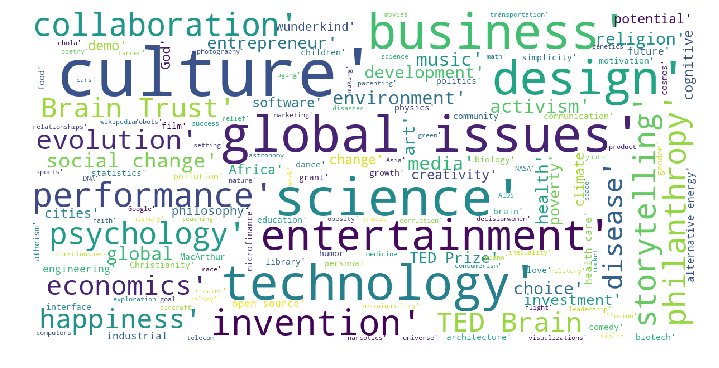

****2007****


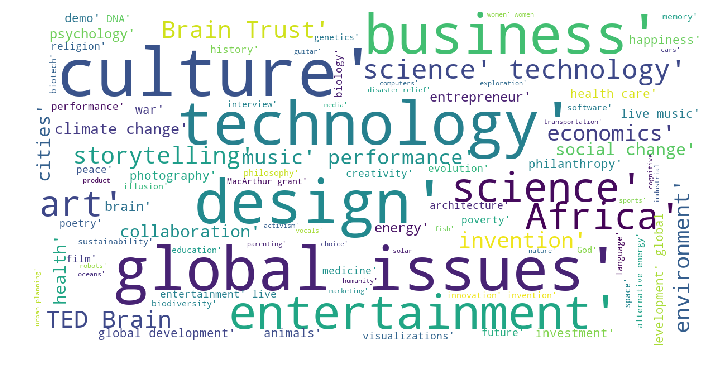

****2008****


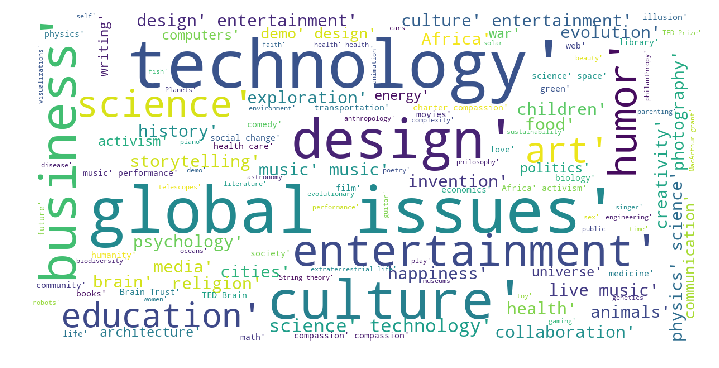

****2009****


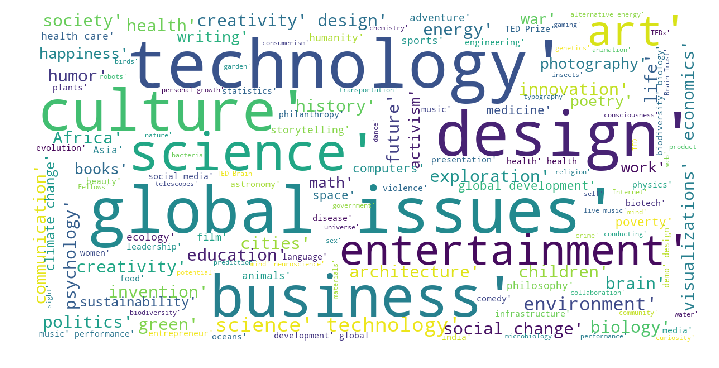

****2010****


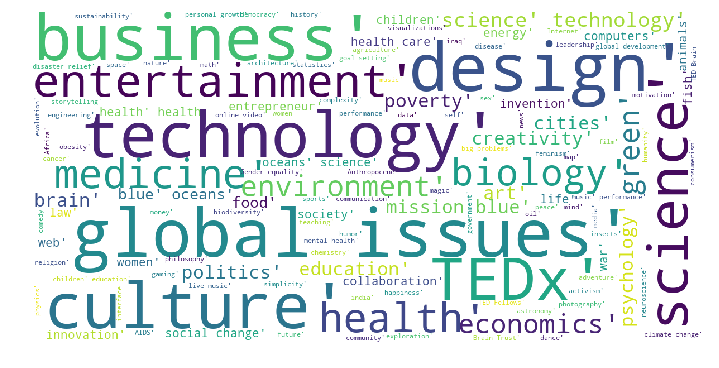

****2011****


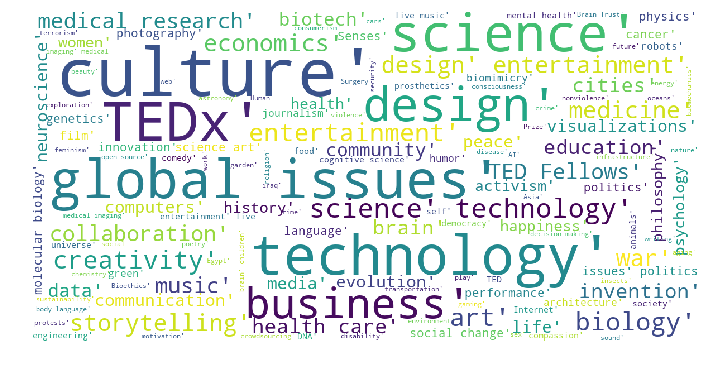

****2012****


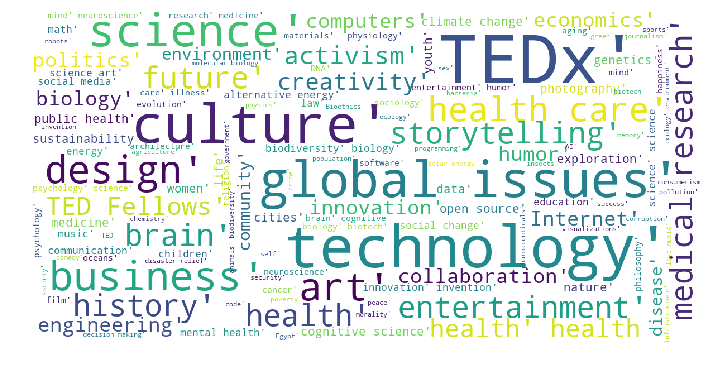

****2013****


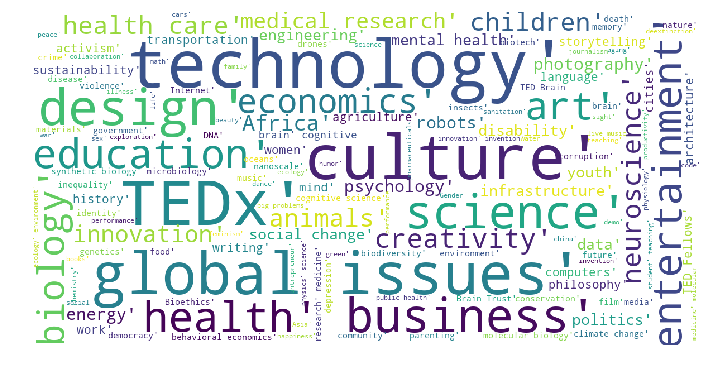

****2014****


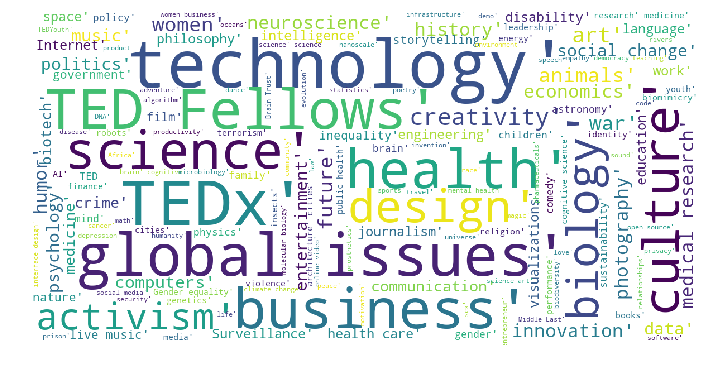

****2015****


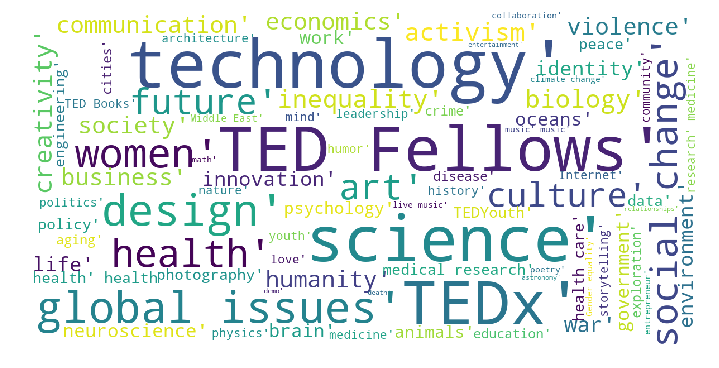

****2016****


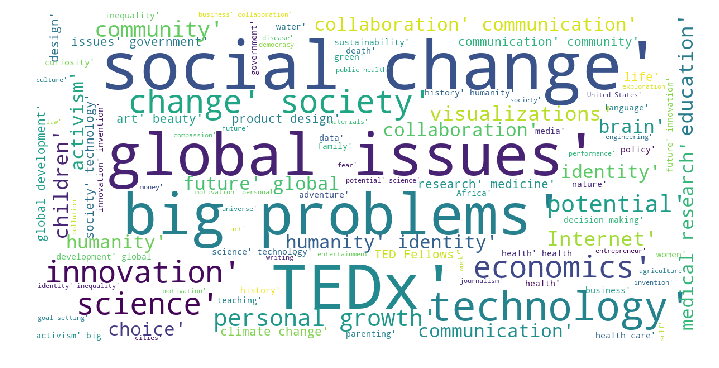

****2017****


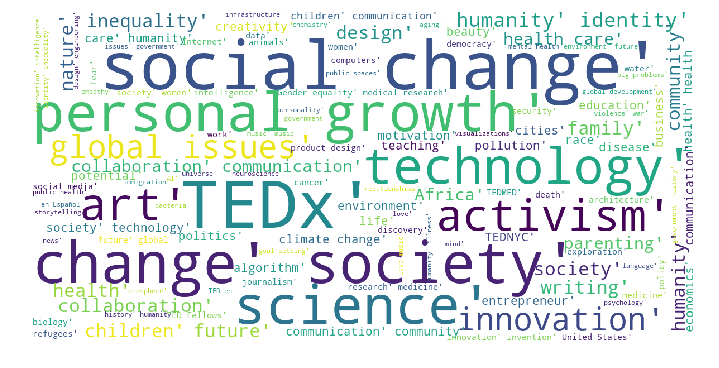

In [48]:
for yr in np.unique(df["yr"]):
    print("****{}****".format(yr))
    show_wordcloud(yearly_tags[yr])

In [49]:
y = df["yr"]

In [50]:
%matplotlib inline

tsne.fit(X, y)
tsne.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

Using SVR

In [51]:
predictions = np.expm1(best_svr.predict(xtest))

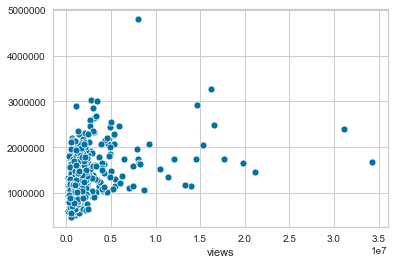

In [72]:
sns.scatterplot(np.expm1(ytest), predictions)

In [90]:
def svr_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6 ,7, 8, 9, 10]
    Cs.extend(list(np.arange(1, 3, 0.1)))
    Cs.extend(list(np.arange(1.4, 1.6, 0.01)))
    param_grid = {'C': Cs}
    grid_search = GridSearchCV(LinearSVR(random_state=42), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [91]:
svr_param_selection(xtrain, ytrain, 5)

{'C': 1.49}

In [92]:
tuned_SVR = LinearSVR(random_state=42, C=1.49)

In [93]:
mae(tuned_SVR)

929946.2745153544